In [1]:
import pandas as pd
import statsmodels.api as sm

# Load Data from CSV files with the correct delimiter
stock_returns = pd.read_csv('/Users/stanley/Data Analytics code/South Africa Company Data.csv' )
market_index_and_risk_free = pd.read_csv('/Users/stanley/Data Analytics code/South Africa Market Return and Risk Free.csv')

# Convert the 'Date' column to datetime and set as index for each DataFrame
stock_returns['Date'] = pd.to_datetime(stock_returns['Date'])
market_index_and_risk_free['Date'] = pd.to_datetime(market_index_and_risk_free['Date'])

# Filter data for the date range using boolean indexing
start_date = '2019-01-31'
end_date = '2023-12-31'
stock_returns = stock_returns[(stock_returns['Date'] >= start_date) & (stock_returns['Date'] <= end_date)]
market_index_and_risk_free = market_index_and_risk_free[(market_index_and_risk_free['Date'] >= start_date) & (market_index_and_risk_free['Date'] <= end_date)]

# Calculate Book-to-Market ratio
stock_returns['Book_to_Market'] = stock_returns['Tangible Book Value'] / stock_returns['Market Capitalisation']

# Drop rows where Market Cap or Return is zero or missing
stock_returns = stock_returns[(stock_returns['Market Capitalisation'] != 0) & (stock_returns['Return'] != 0) & (stock_returns['Book_to_Market'] != 0)]
stock_returns.dropna(subset=['Market Capitalisation', 'Return', 'Book_to_Market'], inplace=True)

# Ensure the columns are of numeric type before performing calculations
market_index_and_risk_free['Rm'] = pd.to_numeric(market_index_and_risk_free['Rm'])
market_index_and_risk_free['Rf'] = pd.to_numeric(market_index_and_risk_free['Rf'])

# Merge stock_returns with market_index_and_risk_free on the 'Date' column
merged_data = pd.merge(stock_returns, market_index_and_risk_free, on='Date', how='left')

# Calculate Mkt-RF and Excess Return
merged_data['Mkt-RF'] = merged_data['Rm'] - merged_data['Rf']
merged_data['Excess_Return'] = merged_data['Return'] - merged_data['Rf']

# Define calculate_factors function using quantiles as required
def calculate_factors(df):
    # Sort stocks based on market cap (50% split)
    median_mc = df['Market Capitalisation'].median()
    small_firms = df[df['Market Capitalisation'] < median_mc]
    big_firms = df[df['Market Capitalisation'] >= median_mc]

    # Sort each size group by book-to-market ratio (tertiles)
    tertiles_bm = df['Book_to_Market'].quantile([0.333, 0.666])

    # Create six portfolios directly
    SL = small_firms[small_firms['Book_to_Market'] <= tertiles_bm.loc[0.333]]
    SM = small_firms[(small_firms['Book_to_Market'] > tertiles_bm.loc[0.333]) & (small_firms['Book_to_Market'] <= tertiles_bm.loc[0.666])]
    SH = small_firms[small_firms['Book_to_Market'] > tertiles_bm.loc[0.666]]

    BL = big_firms[big_firms['Book_to_Market'] <= tertiles_bm.loc[0.333]]
    BM = big_firms[(big_firms['Book_to_Market'] > tertiles_bm.loc[0.333]) & (big_firms['Book_to_Market'] <= tertiles_bm.loc[0.666])]
    BH = big_firms[big_firms['Book_to_Market'] > tertiles_bm.loc[0.666]]

    # Calculating the mean Excess Return for each portfolio
    portfolio_returns = {}
    for portfolio in ('SL', 'SM', 'SH', 'BL', 'BM', 'BH'):
        portfolio_df = locals()[portfolio]
        portfolio_returns[portfolio] = portfolio_df['Excess_Return'].mean()
    
    # Calculating SMB and HML factors
    smb = (portfolio_returns['SL'] + portfolio_returns['SM'] + portfolio_returns['SH']) / 3 - \
          (portfolio_returns['BL'] + portfolio_returns['BM'] + portfolio_returns['BH']) / 3
          
    hml = (portfolio_returns['SH'] + portfolio_returns['BH']) / 2 - \
          (portfolio_returns['SL'] + portfolio_returns['BL']) / 2
          
    return pd.Series({'SMB': smb, 'HML': hml})

# Group by Date and calculate SMB, HML factors
factors = merged_data.groupby('Date').apply(calculate_factors)

# Create a portfolio returns DataFrame
portfolio_returns = merged_data.groupby('Date').agg({'Excess_Return': 'mean', 'Mkt-RF': 'first'}).reset_index()
portfolio_returns = portfolio_returns.rename(columns={'Excess_Return': 'Portfolio_Excess_Return'})

# Merge the portfolio returns with the factors
final_data = pd.merge(portfolio_returns, factors, on='Date')

# Regression analysis with the factors
X = sm.add_constant(final_data[['Mkt-RF', 'SMB', 'HML']])
y = final_data['Portfolio_Excess_Return']

# Fit the model using OLS
model = sm.OLS(y, X).fit()

header_text = "Fama-French Three-Factor Model for South Africa"

console_width = 80

centered_header = header_text.center(console_width)

print(centered_header)

# Print the summary of the model
print(model.summary())

/var/folders/34/00__p08n3qs9pkg2c7stwbqm0000gn/T/ipykernel_78397/2287064590.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_returns['Date'] = pd.to_datetime(stock_returns['Date'])
/var/folders/34/00__p08n3qs9pkg2c7stwbqm0000gn/T/ipykernel_78397/2287064590.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  market_index_and_risk_free['Date'] = pd.to_datetime(market_index_and_risk_free['Date'])


                Fama-French Three-Factor Model for South Africa                 
                               OLS Regression Results                              
Dep. Variable:     Portfolio_Excess_Return   R-squared:                       0.946
Model:                                 OLS   Adj. R-squared:                  0.943
Method:                      Least Squares   F-statistic:                     324.3
Date:                     Mon, 22 Apr 2024   Prob (F-statistic):           2.35e-35
Time:                             18:01:11   Log-Likelihood:                 169.62
No. Observations:                       60   AIC:                            -331.2
Df Residuals:                           56   BIC:                            -322.9
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [2]:
import pandas as pd
from prettytable import PrettyTable
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'X' is your DataFrame containing all the predictor variables
# Calculate VIF for each explanatory variable
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Create a PrettyTable instance
vif_table = PrettyTable()
vif_table.field_names = ["Feature", "VIF"]

# Add data to the table
for i, row in vif_data.iterrows():
    vif_table.add_row([row['feature'], row['VIF']])

# Print the table
print("Variance Inflation Factor (VIF) Results for South Africa:")
print(vif_table)

# Check for multicollinearity
if (vif_data['VIF'] > 10).any():
    print("Warning: High multicollinearity detected in the predictor variables.")
else:
    print("No evidence of multicollinearity issues among the predictor variables.")

Variance Inflation Factor (VIF) Results for South Africa:
+---------+--------------------+
| Feature |        VIF         |
+---------+--------------------+
|  const  | 2.0292022988318945 |
|  Mkt-RF | 1.162838322055422  |
|   SMB   | 1.0346797020568246 |
|   HML   | 1.1812037757593854 |
+---------+--------------------+
No evidence of multicollinearity issues among the predictor variables.


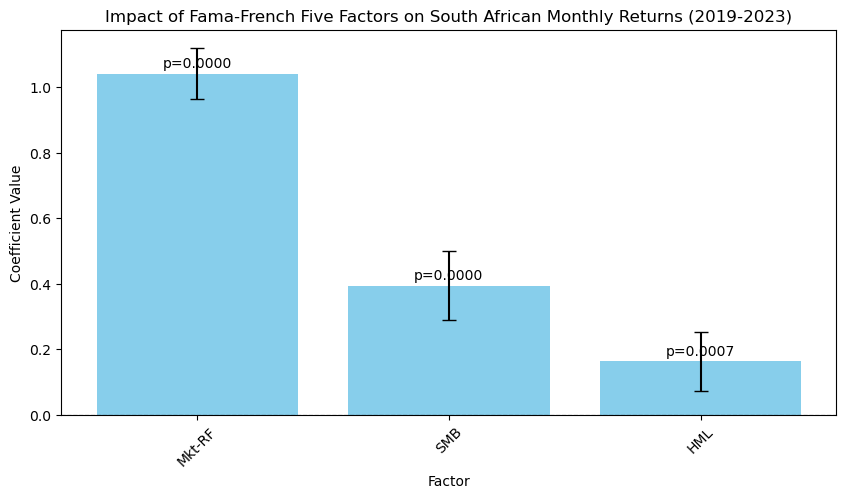

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'model' is your fitted regression model from statsmodels
factors = model.params.index[1:]  # Exclude the intercept
coefficients = model.params.values[1:]
conf_int = model.conf_int().iloc[1:]  # Get confidence intervals for all factors except intercept
errors = (conf_int[1] - conf_int[0]) / 2  # Calculate error margins

# Create a DataFrame for plotting
ols_data = pd.DataFrame({
    "Factor": factors,
    "Coefficient": coefficients,
    "Error": errors,
    "P-Value": model.pvalues[1:]  # Exclude the intercept p-value
})

# Plotting using matplotlib directly to handle categorical data more explicitly
fig, ax = plt.subplots(figsize=(10, 5))

# Create bars with error bars
ax.bar(ols_data['Factor'], ols_data['Coefficient'], yerr=ols_data['Error'], capsize=5, color='skyblue', label='Coefficient')
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")  # Add a horizontal line at zero

# Annotate each bar with p-value
for i, (pval, coef) in enumerate(zip(ols_data['P-Value'], ols_data['Coefficient'])):
    ax.text(i, coef + (0.01 if coef >= 0 else -0.02), f'p={pval:.4f}', color='black', ha='center', va='bottom' if coef >= 0 else 'top')

ax.set_title("Impact of Fama-French Five Factors on South African Monthly Returns (2019-2023)")
ax.set_xlabel("Factor")
ax.set_ylabel("Coefficient Value")
plt.xticks(rotation=45)  # Rotate factor labels for better visibility

plt.show()